In [ ]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet

### To run this project, CUDA drivers need to be on version 10.2+

In [ ]:
# to have cuda 10.2:
!nvcc --version
!sudo rm -rf /usr/local/cuda
!sudo ln -s /usr/local/cuda-10.2 /usr/local/cuda
!nvcc --version

# to upgrade to cuda 11
# !wget https://developer.download.nvidia.com/compute/cuda/11.4.1/local_installers/cuda_11.4.1_470.57.02_linux.run
# !echo "====> Upgrading the driver, this might take a while..."
# !sudo sh cuda_11.4.1_470.57.02_linux.run --silent --driver --toolkit
# !rm -rf cuda_11.4.1_470.57.02_linux.run
# !echo "====> Done!"
# !nvcc --version

### Now we can start running it
First let's adjust some parameters

In [ ]:
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile
!sed -i 's/USE_CPP=0/USE_CPP=1/' Makefile

In [ ]:
!make clean
!make

In [1]:
%cd darknet

/home/ec2-user/SageMaker/darknet


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [13]:
import urllib
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
import darknet
network, class_names, class_colors = darknet.load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = darknet.network_width(network)
height = darknet.network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
    darknet_image = darknet.make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

    # get image ratios to convert bounding boxes to proper size
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height
    
    # run model on darknet style image to get detections
    darknet.copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image)
    darknet.free_image(darknet_image)
    return detections, width_ratio, height_ratio

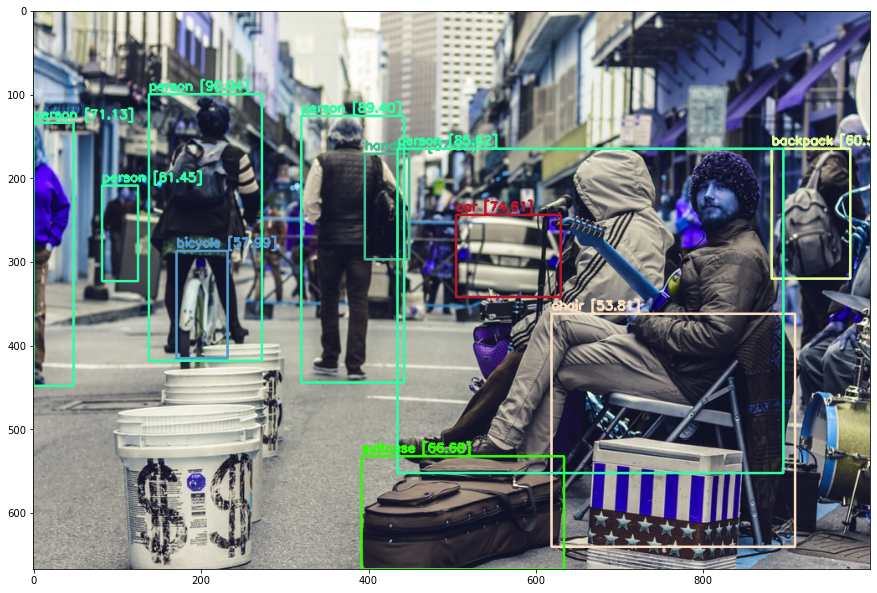

Cloud timer: 0.5170118808746338 seconds
Processing time: 0.5169589519500732 seconds
Inference time: 0.043236494064331055 seconds


In [14]:
req = urllib.request.urlopen('https://raw.githubusercontent.com/MrDio/ImageProcessingInCloudColab/main/in.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)

cloud_timer_start = time.time()
start_cloud_Img = time.time()
start_predict_Img = time.time()

detections, width_ratio, height_ratio = darknet_helper(image, width, height)

end_predict_Img = time.time()

for label, confidence, bbox in detections:
    left, top, right, bottom = darknet.bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)

plt.imshow(image)
plt.show()

end_cloud_Img = time.time()

cloud_timer = time.time() - cloud_timer_start

print(f"Cloud timer: {cloud_timer} seconds")
print(f"Processing time: {end_cloud_Img - start_cloud_Img} seconds")
print(f"Inference time: {end_predict_Img - start_predict_Img} seconds")